# LinkedIn Profile Analysis

We will build a supervised pipeline to classify a profile depending on a subset of tagged data.
Beyond the standard word cleanupfor an NLP pipeline, we should:
- remove hashtag, both word and symbol.
- remove email addresses.
- Symbols.

In [10]:
from tqdm.notebook import tqdm
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
!jupyter nbextension enable - -py widgetsnbextension
tqdm.pandas()


Unrecognized alias: 'py', it will have no effect.
Enabling notebook extension -...
      - Validating: problems found:
        - require?  X -


In [11]:
data = pd.read_csv("./anonLinkedInProfiles.csv")
print(f'Shape: {data.shape}, does it have NAs:\n{data.isna().any()}')
data = data.dropna()
print(f'Post fill NAs:\n{data.isna().any()}')
data['class'] = data['class'].apply(lambda x: x.lower())
data.head()

Shape: (34993, 4), does it have NAs:
user            False
descriptions     True
titles           True
class           False
dtype: bool
Post fill NAs:
user            False
descriptions    False
titles          False
class           False
dtype: bool


,user,descriptions,titles,class
0,Lawrence Dickerson,it's professional with skills microsoft excel ...,it business partner w seargin coordinating glo...,w
1,Lois Guerrero,employer brandingcommunicationshuman resources...,chief executive officer,f
2,Curt Henke,we are still hiring know anyone who might be i...,talent accquistion,s
3,Bertha Bailey,rdekel a tzsde vilga de nincs idd kvetni a hre...,senior financial markets specialist at kbc sec...,f
4,Thomas Kim,skills natural language processing nlp alpha g...,data scientist at blackrock,o


For spaCy:

```
pip install -U pip setuptools wheel
pip install -U spacy
python -m spacy download en_core_web_sm
```

See https://spacy.io/usage. We will use a multi-langauge model.

In [12]:
import spacy

nlp = spacy.load('en_core_web_sm')

In [13]:
import string
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import TransformerMixin
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.base import TransformerMixin

NGRAMS = (1,3) # BGrams only
punctuations = string.punctuation

SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”", "|", "#"]
COMMON_WORDS = [] # to be populated later in our analysis

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    tokens = nlp(sentence)
    tokens = [word.lemma_.lower().strip() if word.lemma_ !=
              "-PRON-" else word.lower_ for word in tokens]
    tokens = [tok for tok in tokens if (tok not in STOP_WORDS and tok not in SYMBOLS and tok not in COMMON_WORDS)]
    return tokens

class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}


def clean_text(text):
    if (type(text) == str):
        text = text.strip().replace("\n", " ").replace("\r", " ")
        text = text.lower()
    else:
        text = "NA"
    return text


# With the BoW, the model does a bit better.
bow_vector = CountVectorizer(
    tokenizer=spacy_tokenizer, ngram_range=NGRAMS)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

# Combine features for NLP.
X = data['titles'].astype(str) +  ' ' + data['descriptions'].astype(str)
# X = data['titles']
# X = data['descriptions']
ylabels = le.fit_transform(data['class'])

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3) # no need for strat, doesn't reflect reality.

  0%|          | 0/7040 [00:00<?, ?it/s]

C:\Users\bigworker\AppData\Local\Temp\ipykernel_25876\222654301.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(y1, rotation=0)


  0%|          | 0/56886 [00:00<?, ?it/s]

C:\Users\bigworker\AppData\Local\Temp\ipykernel_25876\222654301.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(y, rotation=0)


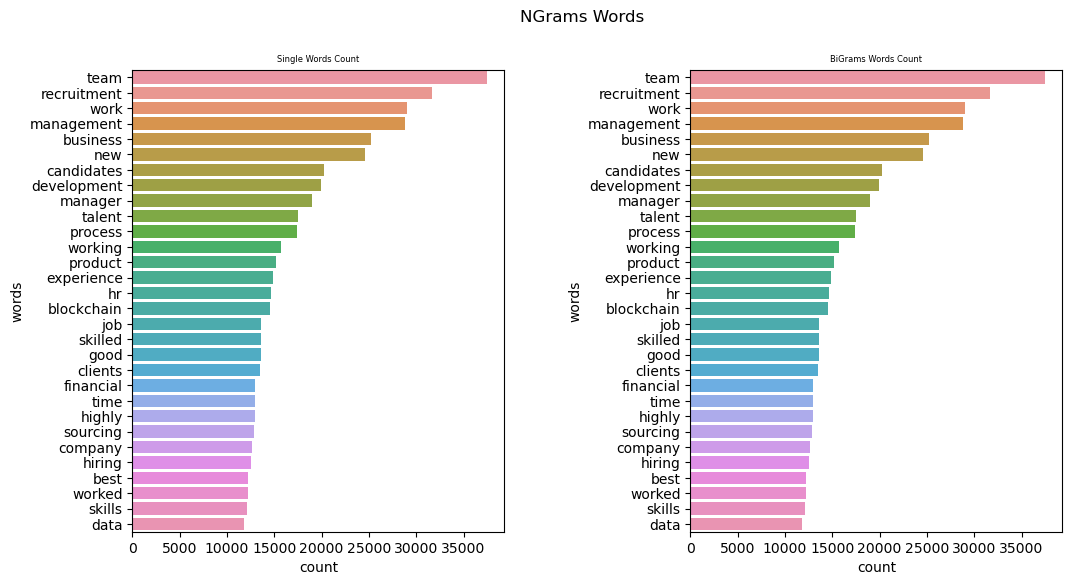

Common words Q3 19724.0 and common bigrams 19724.0


In [15]:
def get_top_n_ngrams(corpus, ngram, stop_words='english', n=None):
    vec = CountVectorizer(ngram_range=ngram, stop_words=stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in tqdm(vec.vocabulary_.items())]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

TOP_N_WORDS = 30

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
fig.suptitle('NGrams Words')
fig.subplots_adjust(hspace=0.125, wspace=0.50)

# first
common_words = get_top_n_ngrams(X, ngram=(1, 1), n=TOP_N_WORDS)
common_words_df = pd.DataFrame(common_words, columns=['words', 'count'])
x1, y1 =  common_words_df['count'], common_words_df['words']

axes[0].set_title('Single Words Count', fontsize=6)
axes[0].set_yticklabels(y1, rotation=0)
sns.barplot(ax=axes[0], x=x1, y=y1)

# Second
common_bigrams = get_top_n_ngrams(X, ngram=NGRAMS, n=TOP_N_WORDS)
common_bigrams_df = pd.DataFrame(common_bigrams, columns=['words', 'count'])
x, y =  common_bigrams_df['count'], common_bigrams_df['words']

axes[1].set_title('BiGrams Words Count', fontsize=6)
axes[1].set_yticklabels(y, rotation=0)
sns.barplot(ax=axes[1], x=x, y=y)

plt.show()
word_q3 = np.percentile(common_words_df["count"], 75)
ngram_q3 = np.percentile(common_bigrams_df["count"], 75)
print(
    f'Common words Q3 {word_q3} and common bigrams {ngram_q3}')

#COMMON_WORDS = common_words_df[common_words_df['count'] > word_q3]['words']
#COMMON_WORDS = COMMON_WORDS.apply(lambda x: [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in nlp(x)][0])
#COMMON_WORDS = COMMON_WORDS.to_numpy()
#COMMON_WORDS

<function matplotlib.pyplot.show(close=None, block=None)>

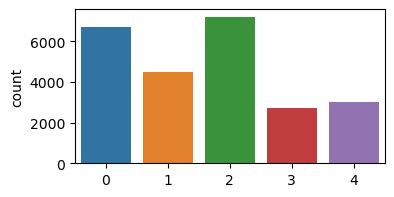

In [16]:
import seaborn as sns
plt.figure(figsize=(4,2))
sns.countplot(x=y_train)
plt.show

Since our training dataset is unbalanced, we need to resample or use weights. Also drop nGrams that are overused.

(3861, 4), (3861, 4), (3861, 4), (3861, 4), (3861, 4)


  0%|          | 0/964 [00:00<?, ?it/s]

C:\Users\bigworker\AppData\Local\Temp\ipykernel_25876\1046652236.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][0].set_yticklabels(y1, rotation=0)


  0%|          | 0/1690 [00:00<?, ?it/s]

C:\Users\bigworker\AppData\Local\Temp\ipykernel_25876\1046652236.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][1].set_yticklabels(y2, rotation=0)


  0%|          | 0/2620 [00:00<?, ?it/s]

C:\Users\bigworker\AppData\Local\Temp\ipykernel_25876\1046652236.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][2].set_yticklabels(y3, rotation=0)


  0%|          | 0/1226 [00:00<?, ?it/s]

C:\Users\bigworker\AppData\Local\Temp\ipykernel_25876\1046652236.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][0].set_yticklabels(y4, rotation=0)


  0%|          | 0/1958 [00:00<?, ?it/s]

C:\Users\bigworker\AppData\Local\Temp\ipykernel_25876\1046652236.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][1].set_yticklabels(y5, rotation=0)


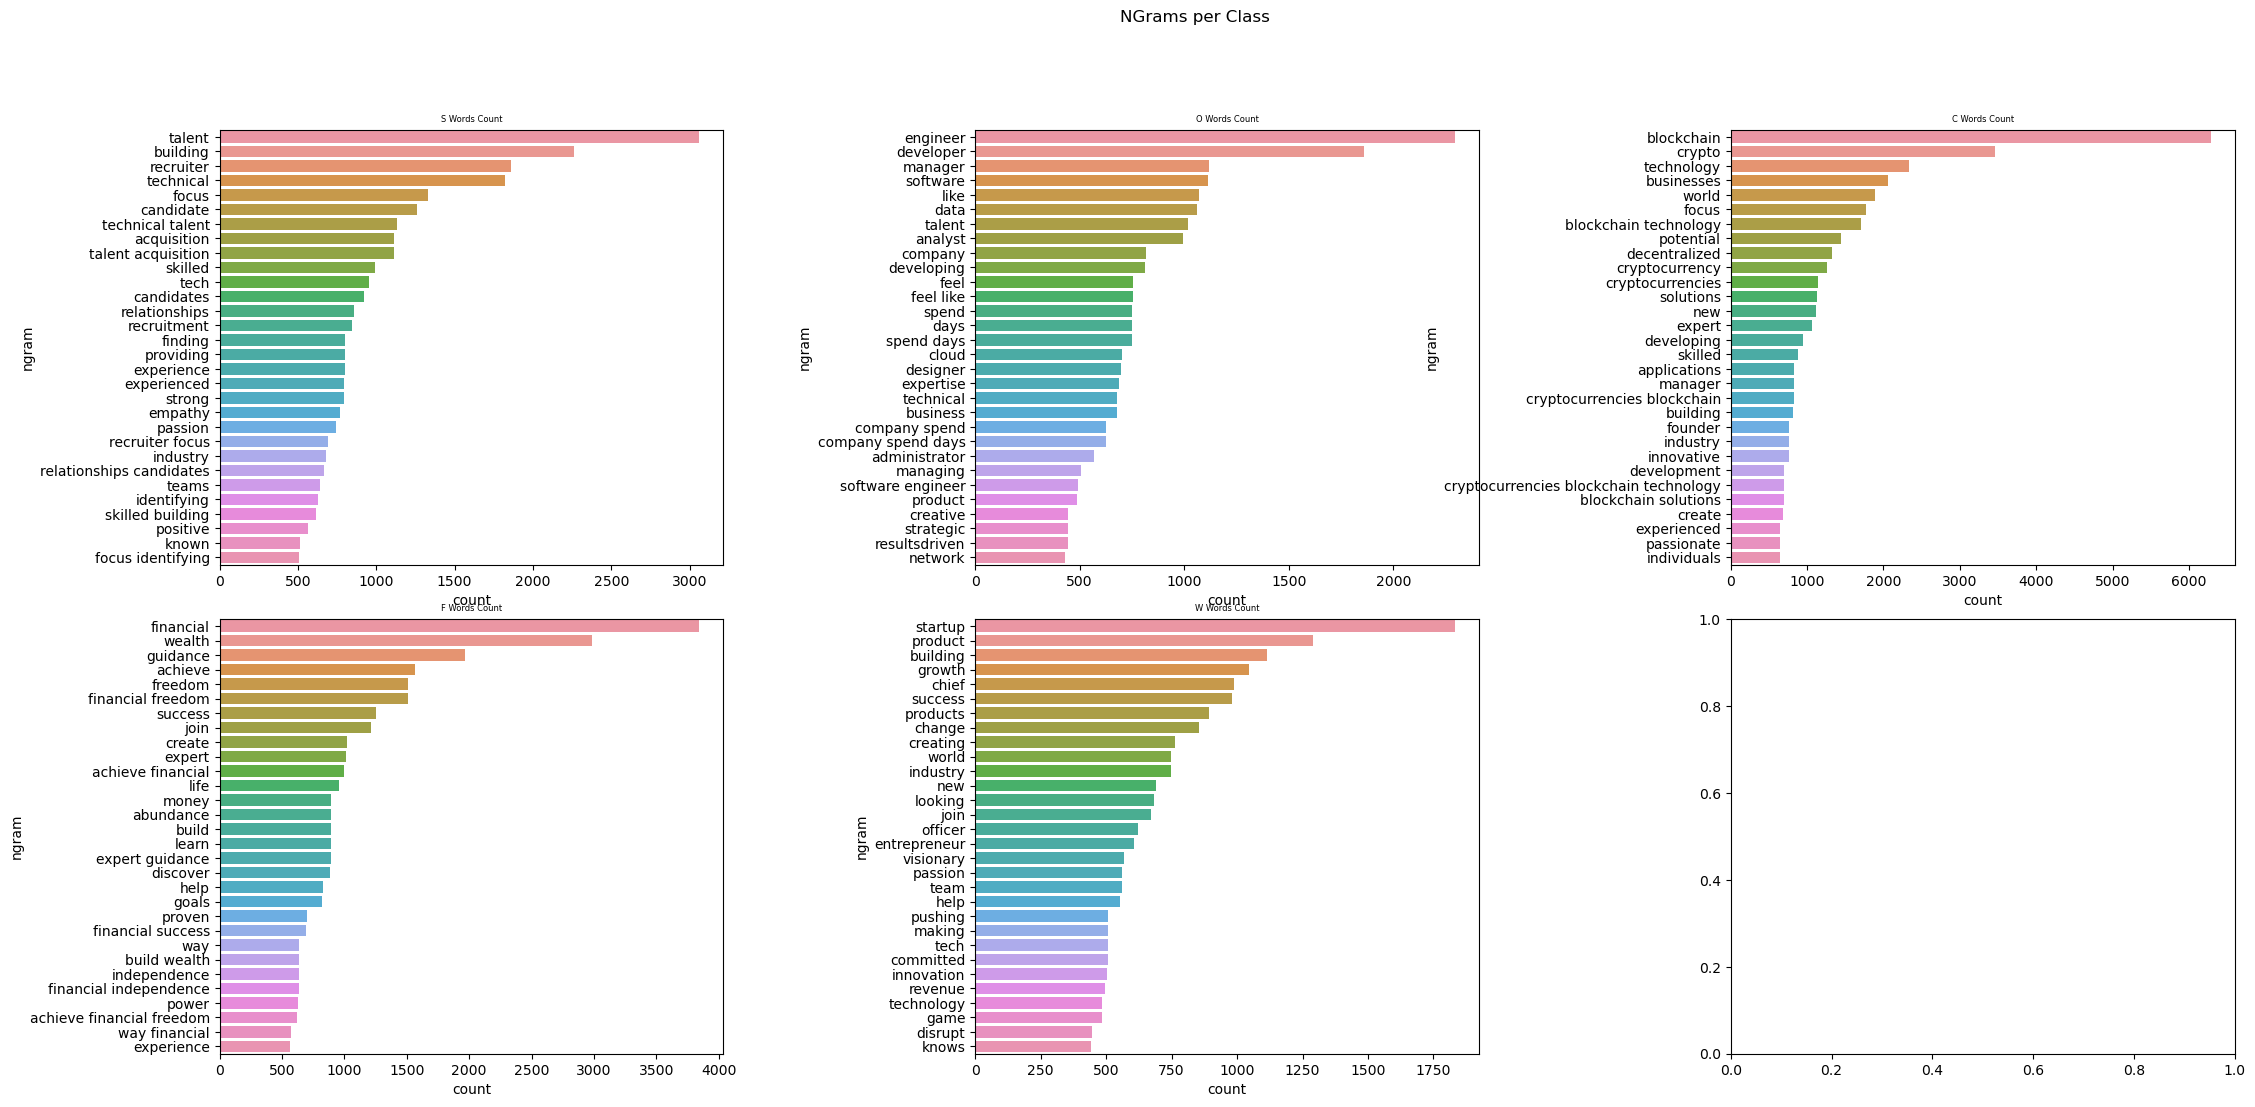

In [17]:
from sklearn.utils.class_weight import compute_class_weight

keys = np.unique(y_train)
values = compute_class_weight(class_weight='balanced', classes=keys, y=y_train)

class_weights = dict(zip(keys, values))

# undersmaple
data4 = data[data['class'] == 's']
data3 = data[data['class'] == 'o'].sample(n=len(data4), random_state=101)
data2 = data[data['class']=='c'].sample(n=len(data4), random_state=101)
data1 = data[data['class']=='f'].sample(n=len(data4), random_state=101)
data0 = data[data['class']=='w'].sample(n=len(data4), random_state=101)

data_under = pd.concat([data0,data1,data2,data3,data4],axis=0)

print(f'{data0.shape}, {data1.shape}, {data2.shape}, {data3.shape}, {data4.shape}')

# Combine features for NLP.
X = data_under['titles'].astype(str) + ' ' + data_under['descriptions'].astype(str)
ylabels = le.fit_transform(data_under['class'])

# no need for strat, doesn't reflect reality.
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

fig, axes = plt.subplots(2, 3, figsize=(26, 12), sharey=False)
fig.suptitle('NGrams per Class')
fig.subplots_adjust(hspace=0.125, wspace=0.50)

common_ngrams = get_top_n_ngrams(
    data[data['class'] == 's']['titles'], ngram=NGRAMS, n=TOP_N_WORDS)
common_ngrams_df = pd.DataFrame(common_ngrams, columns=['ngram', 'count'])
x1, y1 = common_ngrams_df['count'], common_ngrams_df['ngram']
axes[0][0].set_title('S Words Count', fontsize=6)
axes[0][0].set_yticklabels(y1, rotation=0)
sns.barplot(ax=axes[0][0], x=x1, y=y1)

common_ngrams = get_top_n_ngrams(
    data[data['class'] == 'o']['titles'], ngram=NGRAMS, n=TOP_N_WORDS)
common_ngrams_df = pd.DataFrame(common_ngrams, columns=['ngram', 'count'])
x2, y2 = common_ngrams_df['count'], common_ngrams_df['ngram']
axes[0][1].set_title('O Words Count', fontsize=6)
axes[0][1].set_yticklabels(y2, rotation=0)
sns.barplot(ax=axes[0][1], x=x2, y=y2)

common_ngrams = get_top_n_ngrams(
    data[data['class'] == 'c']['titles'], ngram=NGRAMS, n=TOP_N_WORDS)
common_ngrams_df = pd.DataFrame(common_ngrams, columns=['ngram', 'count'])
x3, y3 = common_ngrams_df['count'], common_ngrams_df['ngram']
axes[0][2].set_title('C Words Count', fontsize=6)
axes[0][2].set_yticklabels(y3, rotation=0)
sns.barplot(ax=axes[0][2], x=x3, y=y3)

common_ngrams = get_top_n_ngrams(
    data[data['class'] == 'f']['titles'], ngram=NGRAMS, n=TOP_N_WORDS)
common_ngrams_df = pd.DataFrame(common_ngrams, columns=['ngram', 'count'])
x4, y4 = common_ngrams_df['count'], common_ngrams_df['ngram']
axes[1][0].set_title('F Words Count', fontsize=6)
axes[1][0].set_yticklabels(y4, rotation=0)
sns.barplot(ax=axes[1][0], x=x4, y=y4)

common_ngrams = get_top_n_ngrams(
    data[data['class'] == 'w']['titles'], ngram=NGRAMS, n=TOP_N_WORDS)
common_ngrams_df = pd.DataFrame(common_ngrams, columns=['ngram', 'count'])
x5, y5 = common_ngrams_df['count'], common_ngrams_df['ngram']
axes[1][1].set_title('W Words Count', fontsize=6)
axes[1][1].set_yticklabels(y5, rotation=0)
sns.barplot(ax=axes[1][1], x=x5, y=y5)

plt.show()

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

# Creating our tokenizer function
tfidf = TfidfVectorizer(tokenizer=spacy_tokenizer,
                        sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2))
bow = CountVectorizer(ngram_range=(1, 2))

features = tfidf.fit_transform(data['titles'], data['class']).toarray()
labels = data['class'].unique()
print("Each of the %d descriptions is represented by %d features (TF-IDF score of unigrams and bigrams)" % (features.shape))
# Dictionaries for future use
N = 3
for label in labels:
  features_chi2 = chi2(features, data['class'] == label)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("n==> %s:" %(label))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))

c:\Users\bigworker\anaconda3\envs\tutorials\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\bigworker\anaconda3\envs\tutorials\Lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'whereaft'] not in stop_words.
  warnings.warn(


Each of the 34549 descriptions is represented by 4110 features (TF-IDF score of unigrams and bigrams)
n==> w:
  * Most Correlated Unigrams are: push, chief, startup
  * Most Correlated Bigrams are: create product, product change, build product
n==> f:
  * Most Correlated Unigrams are: guidance, financial, wealth
  * Most Correlated Bigrams are: achieve financial, build wealth, financial freedom
n==> s:
  * Most Correlated Unigrams are: talent, candidate, recruiter
  * Most Correlated Bigrams are: relationship candidate, talent acquisition, technical talent
n==> o:
  * Most Correlated Unigrams are: cloud, developer, engineer
  * Most Correlated Bigrams are: database administrator, network engineer, software engineer
n==> c:
  * Most Correlated Unigrams are: technology, crypto, blockchain
  * Most Correlated Bigrams are: blockchain solution, cryptocurrencie blockchain, blockchain technology


In [19]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

lgc = LogisticRegression(n_jobs=-1)

lsvm_params = {'C': [1, 100], 'loss': ['hinge', 'squared_hinge'], 'class_weight': [class_weights,'balanced']}
lsvm_clf = GridSearchCV(LinearSVC(), lsvm_params, cv=5)

# sgdc = SGDClassifier(n_jobs=-1, 
#                        loss='hinge', penalty='l2',
#                        alpha=1e-3, random_state=42,
#                        max_iter=5, tol=None)
# estimators = [ ('lsv', lsvm_clf), ('sgdc', sgdc)]
# sclf = StackingClassifier(estimators=estimators,
#                          final_estimator=lgc,
#                          passthrough=True)
# mnbclf = MultinomialNB(fit_prior=False)
tfidf = TfidfTransformer(use_idf=True)


# To find out for the param grid.
text_clf = Pipeline(steps=[
        ("cleaner", predictors()),
        ('vect', bow_vector),
        ('tfidf', tfidf),
        ('clf', lsvm_clf),
    ],
    verbose=True)
text_model_clf = text_clf.fit(X_train, y_train)


parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 3)],
    'tfidf__use_idf': (True, False),
    'tfidf__sublinear_tf': (True, False)
}
model_clf = GridSearchCV(estimator=text_model_clf,
                      param_grid=parameters,
                      cv=5, n_jobs=-1)
model = model_clf.fit(X_train, y_train)
predicted = model.predict(X_test)

# Model Accuracy
print("F1:", metrics.f1_score(y_test, predicted, average='weighted'))
print("Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Precision:",metrics.precision_score(y_test, predicted,average='weighted'))
print("Recall:",metrics.recall_score(y_test, predicted,average='weighted'))

#Ploting the confusion matrix
plt.figure(figsize=(2, 2))
cm= metrics.confusion_matrix(y_test, predicted)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)

disp.plot()

[Pipeline] ........... (step 1 of 4) Processing cleaner, total=   0.0s


c:\Users\bigworker\anaconda3\envs\tutorials\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",model.best_estimator_)
print("\n The best score across ALL searched params:\n",model.best_score_)
print("\n The best parameters across ALL searched params:\n",model.best_params_)